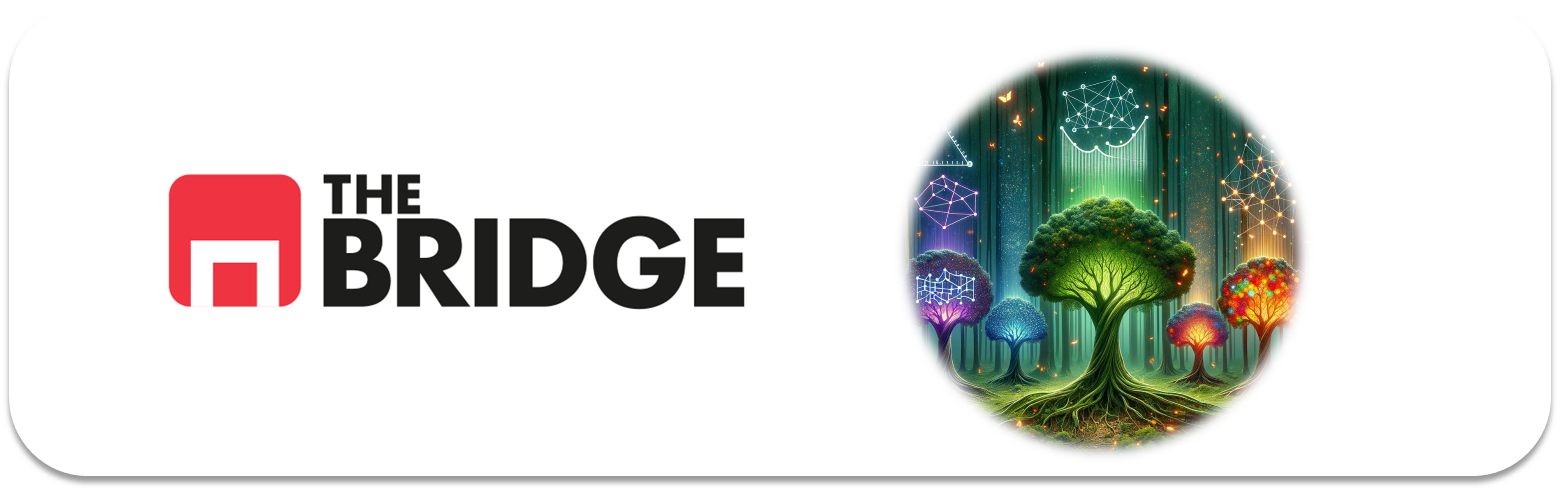

## PRÁCTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import bootcampviztools as bt
import viz_tools as vt

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
names = ['n_preg', 'glyc', 'dbp', 'skin', 'insul', 'bmi', 'pedi', 'age', 'dx']

df = pd.read_csv(url, names = names)

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

#### 1. Exploración inicial dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   n_preg  768 non-null    int64  
 1   glyc    768 non-null    int64  
 2   dbp     768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insul   768 non-null    int64  
 5   bmi     768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   dx      768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Comprobación de tipos y nunique

columns = {col: {'nunique': df[col].nunique(), 'type': df[col].dtype} for col in df.columns}
pd.DataFrame(columns).T.sort_values('nunique')

,nunique,type
dx,2,int64
n_preg,17,int64
dbp,47,int64
skin,51,int64
age,52,int64
glyc,136,int64
insul,186,int64
bmi,248,float64
pedi,517,float64


In [5]:
# Comprobación de missings ocultos

for col in df.columns:
    print(f'{col} (unkowns or missings):', end = ' ')
    try:
        missings = df[col].value_counts()['unknown']
        other = df[col].value_counts()['other']
        
        print(f'{missings}, {round(missings / len(df) * 100.0,2)}%')
        print(f'{other}, {round(other / len(df) * 100.0,2)}%')
    except:
        print(0)

n_preg (unkowns or missings): 0
glyc (unkowns or missings): 0
dbp (unkowns or missings): 0
skin (unkowns or missings): 0
insul (unkowns or missings): 0
bmi (unkowns or missings): 0
pedi (unkowns or missings): 0
age (unkowns or missings): 0
dx (unkowns or missings): 0


Todas las features son numéricas, la que consideramos target es la única categórica (binaria).

#### 2. Separación train-test, visualización de target y features

In [6]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [7]:
target = 'dx'

y_train = train[target]
y_test = test[target]

X_train = train.drop(target, axis = 1)
X_test = test.drop(target, axis = 1)

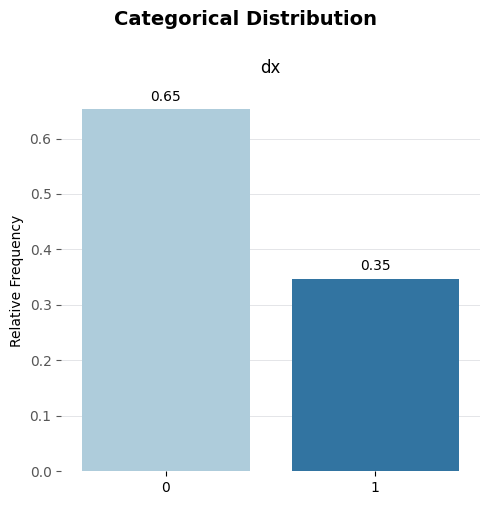

In [8]:
vt.plot_categorical_distribution(train, target, relative = True, show_values = True, palette = 'Paired', rotation = 0)

Es un problema de clasificación binaria donde el target está desbalanceado. Se ajustará el hiperparámetro de class_weight posteriormente en los modelos a usar.

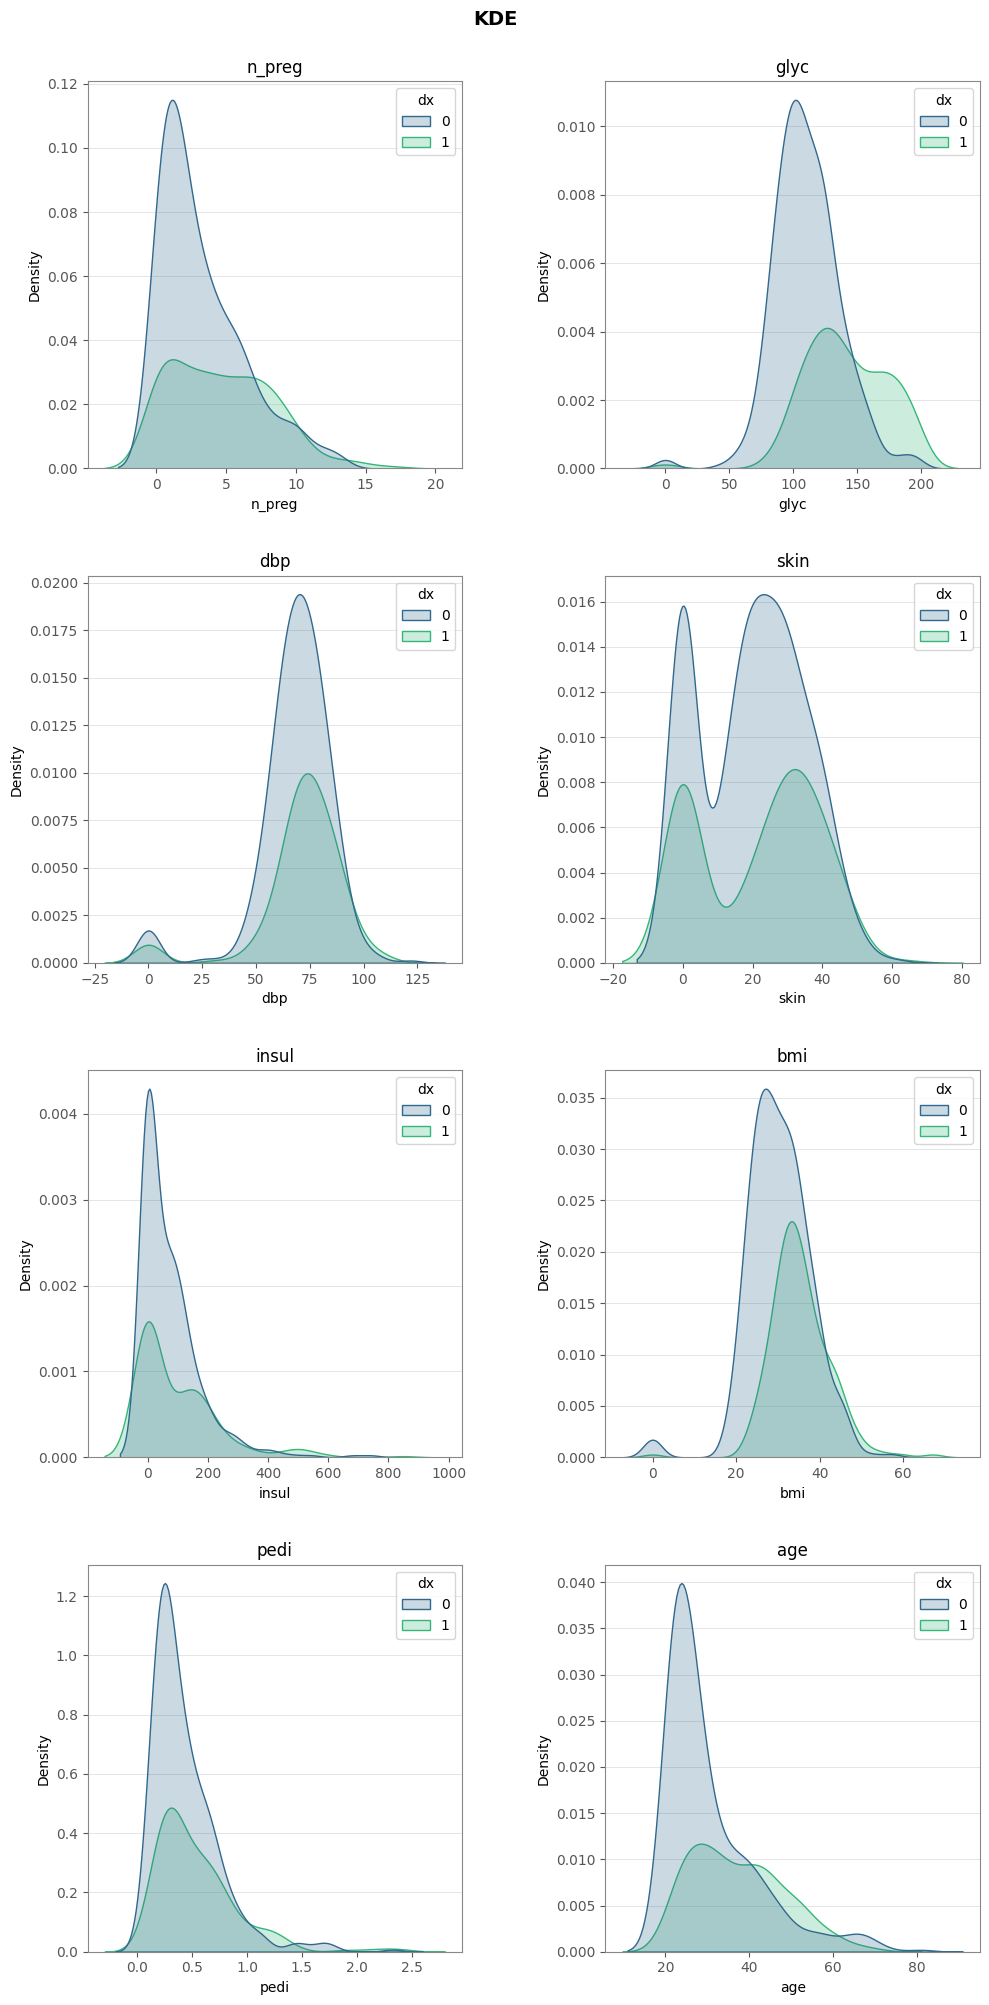

In [9]:
# Features

vt.plot_kde(train, target, n_columns = 2)


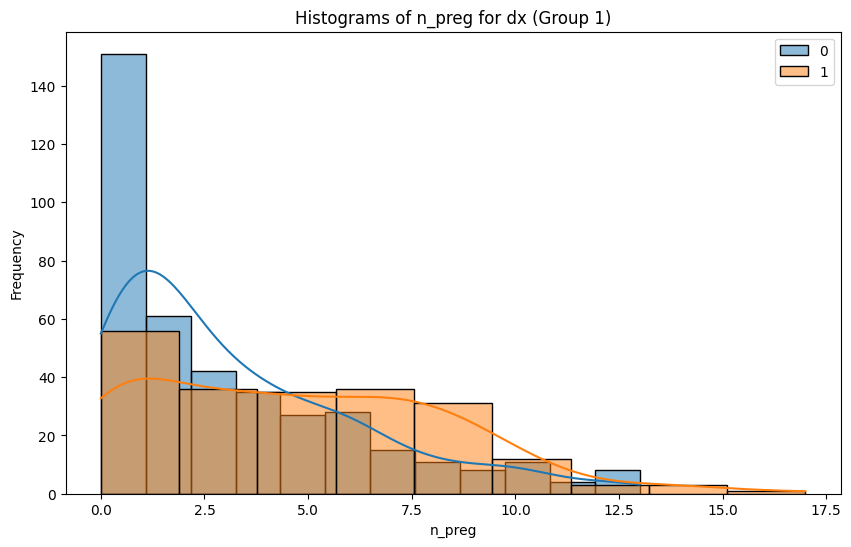

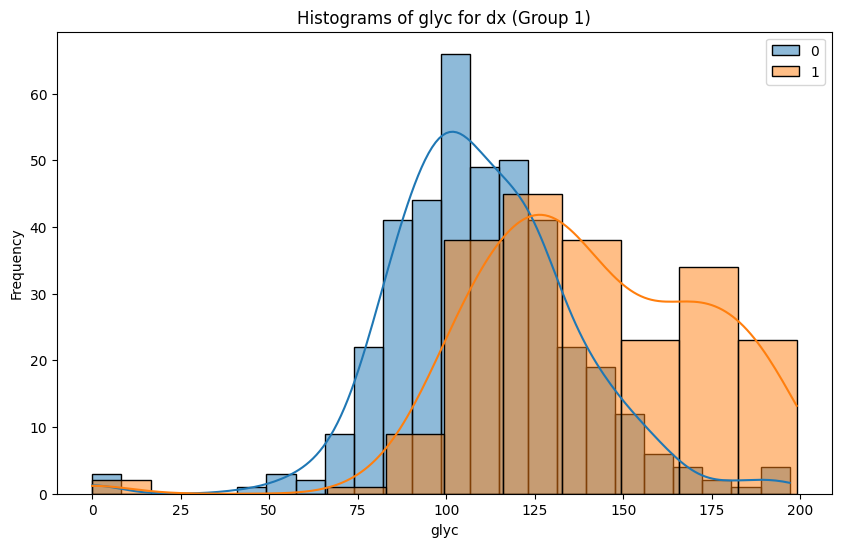

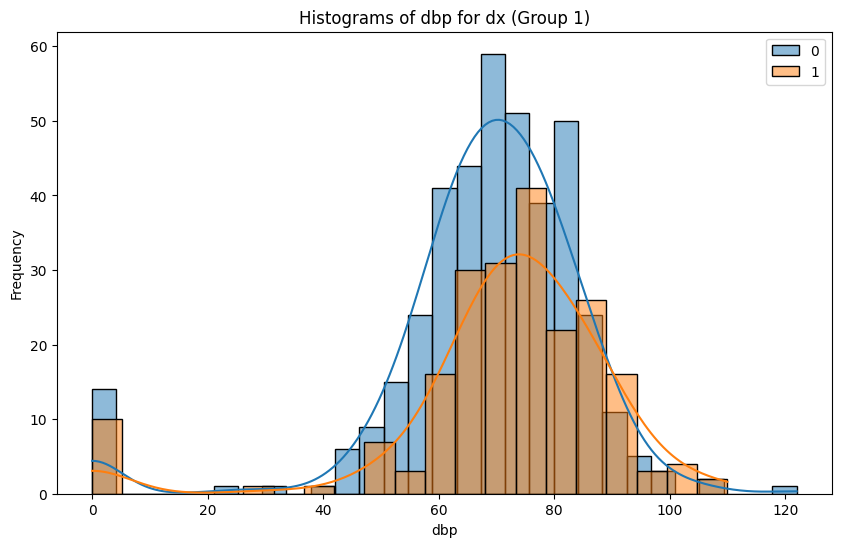

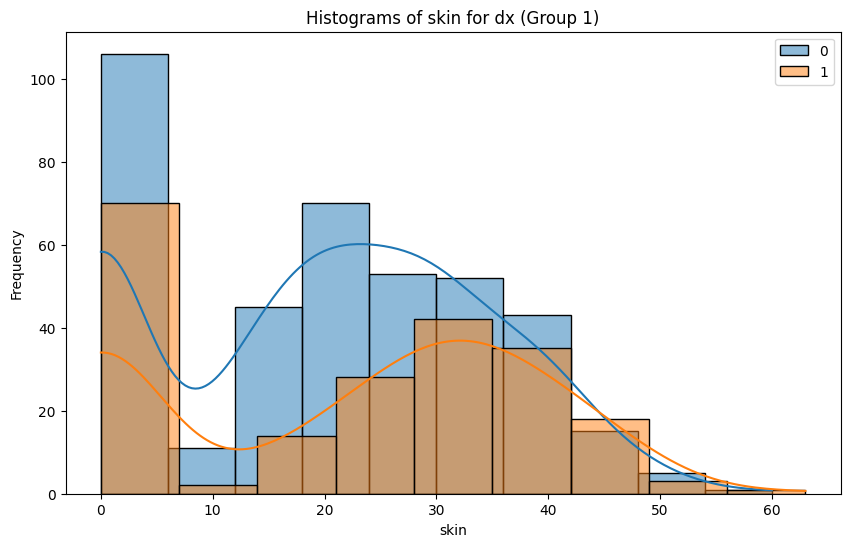

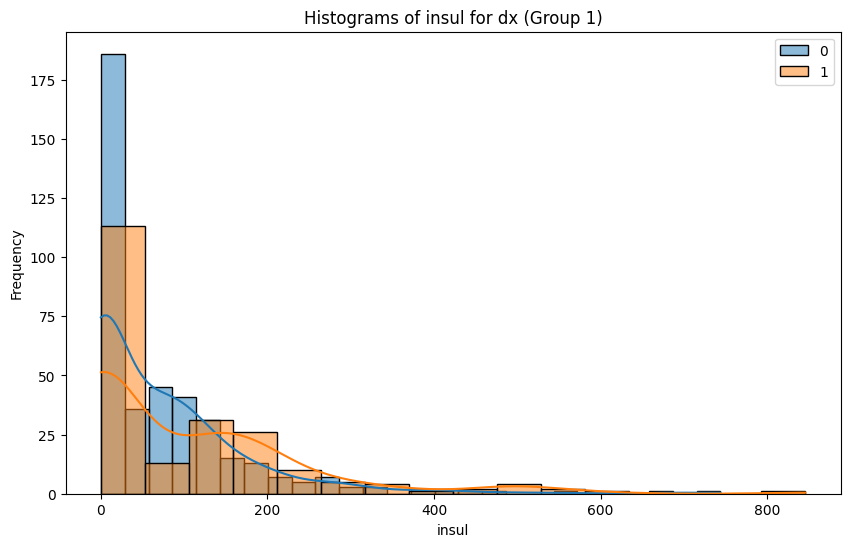

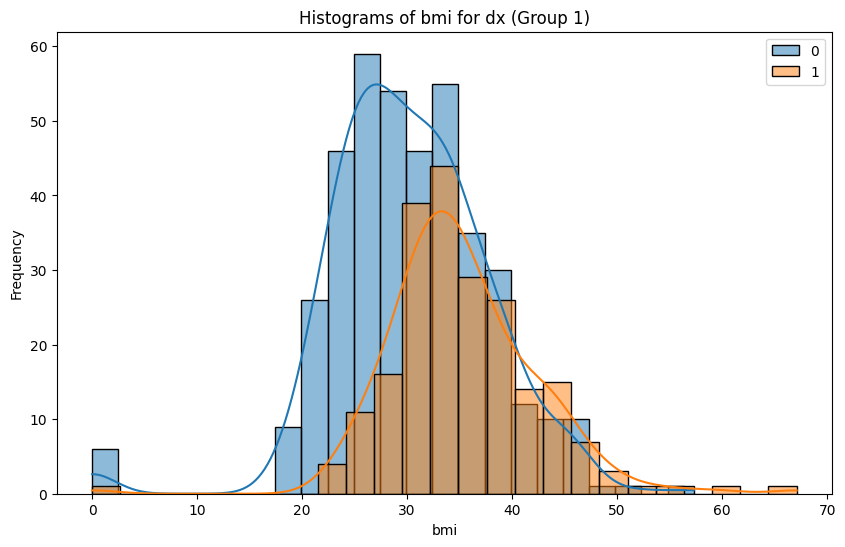

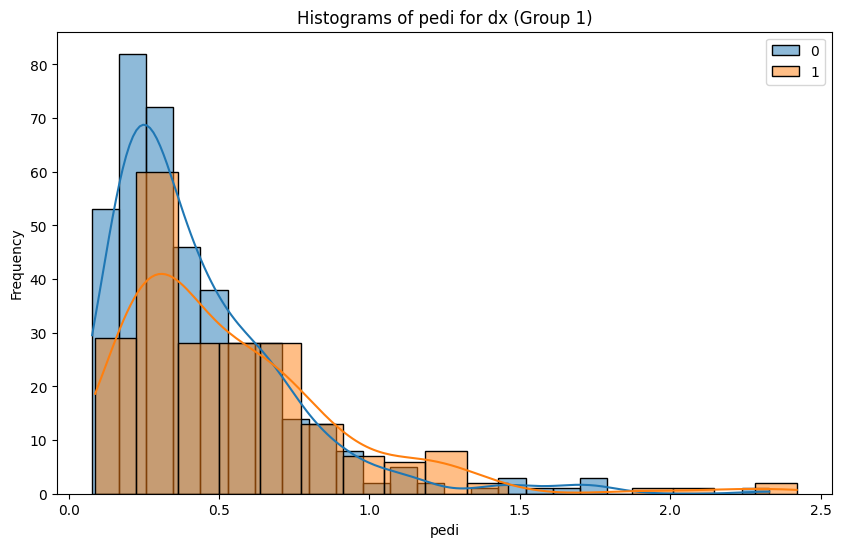

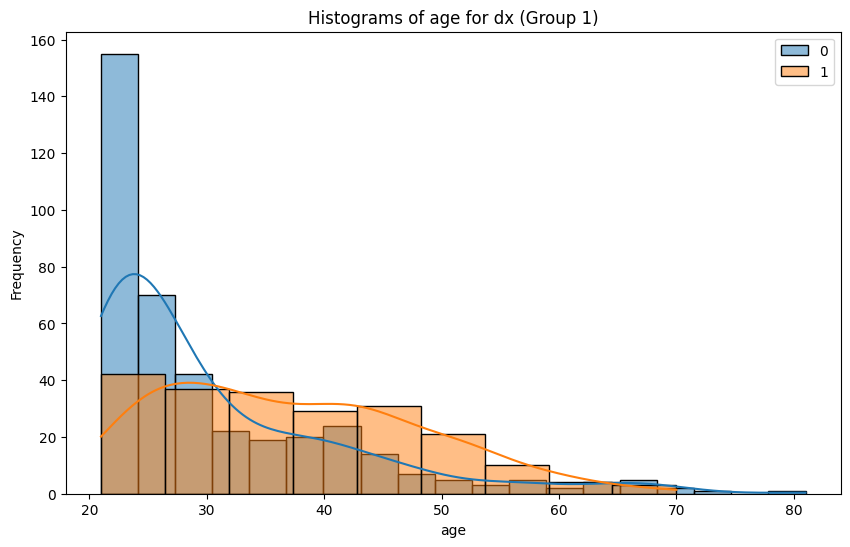

In [10]:
for col in X_train:
    bt.plot_grouped_histograms(train, target, col, group_size = 2)

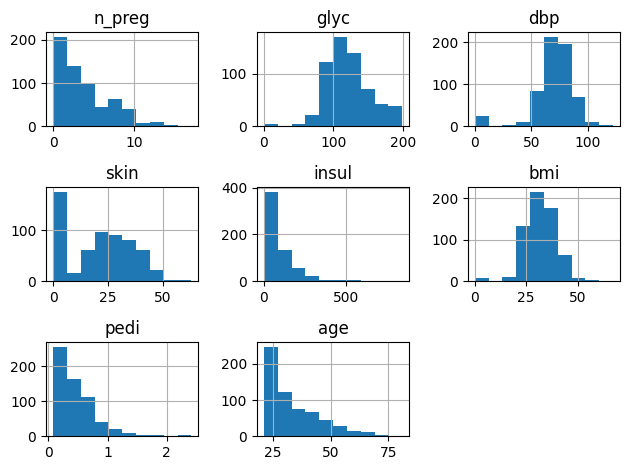

In [11]:
X_train.hist()
plt.tight_layout()

Las menos significativas son skin y dbp, de momento las dejo porque hay muy pocas features en este dataset.  

Voy a usar un modelo de regresión logística para comparar, por lo que voy a hacer transformación logarítmica de n_preg, skin, insul, pedi y age (porque son las que no tienen forma acampanada) y estandarización de las features.

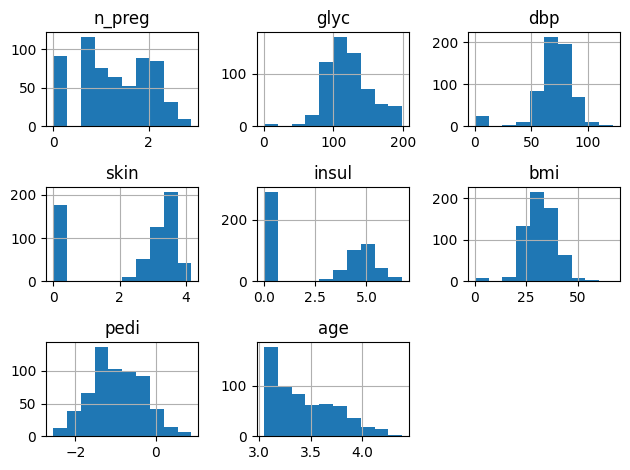

In [12]:
for col in ['n_preg', 'skin', 'insul', 'pedi', 'age']:
    min_val = min(X_train[col])
    if min_val <= 0:
        X_train[col] = np.log1p(X_train[col])
    else:
        X_train[col] = np.log(X_train[col])

X_train.hist()
plt.tight_layout()

In [13]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [14]:
X_train.describe()

,n_preg,glyc,dbp,skin,insul,bmi,pedi,age
count,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02
mean,7.811341e-17,-2.169817e-17,6.943414e-17,1.967301e-16,2.314471e-17,-5.699386e-16,7.305051e-17,8.172977e-16
std,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00
min,-1.679881e+00,-3.775663e+00,-3.752683e+00,-1.545606e+00,-1.035420e+00,-4.135256e+00,-2.452134e+00,-1.247130e+00
25%,-7.767182e-01,-6.515379e-01,-2.927587e-01,-1.545606e+00,-1.035420e+00,-6.313921e-01,-7.013092e-01,-8.263972e-01
50%,1.264448e-01,-1.204366e-01,1.397318e-01,5.248868e-01,5.024521e-01,2.147879e-03,-2.994275e-02,-2.301299e-01
75%,8.556180e-01,5.668710e-01,5.722222e-01,7.323585e-01,9.510867e-01,5.678085e-01,7.436589e-01,7.831219e-01
max,2.086241e+00,2.441346e+00,2.842797e+00,1.163894e+00,1.712714e+00,4.540363e+00,2.869049e+00,3.006244e+00


#### 3. Modelado

Los modelos a usar son:
* Regresión logística
* 

In [15]:
optimized_metrics = {}

In [16]:
### Logistic Regression

lgr = LogisticRegression(random_state = 42)
lgr_params = {
    'max_iter': [1000, 2000, 5000, 10000],
    'penalty': ['l2', None],
    'C': [0.1,0.5,1],
}
lgr_grid = RandomizedSearchCV(lgr,
                             cv = 5,
                             n_iter = 20,
                             param_distributions = lgr_params,
                             scoring = 'accuracy',
                             n_jobs = -1)

lgr_grid.fit(X_train,y_train)
print('LR best_score:', lgr_grid.best_score_)
print('LR best_params:', lgr_grid.best_params_)
optimized_metrics['LogisticRegression'] = lgr_grid.best_score_

/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mar

LR best_score: 0.767093162734906
LR best_params: {'penalty': None, 'max_iter': 1000, 'C': 0.1}


/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mar

In [17]:
rf_clf = RandomForestClassifier(random_state = 42)

rf_params = {
    'n_estimators': [100,200,400],
    'max_depth': [2,4,10],
    'min_samples_leaf': [10,20,40],
    'max_features': ['sqrt','log2',None],
    'max_samples': [0.3,0.6,1],
    'class_weight': ['balanced', None]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions = rf_params, 
                               scoring = 'accuracy',
                               n_jobs = -1)

rf_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [2, 4, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [0.3, 0.6, 1],
                                        'min_samples_leaf': [10, 20, 40],
                                        'n_estimators': [100, 200, 400]},
                   scoring='accuracy')

In [18]:
print('RF best_score:', rf_grid.best_score_)
print('RF best_params:', rf_grid.best_params_)
optimized_metrics['RandomForest'] = rf_grid.best_score_

RF best_score: 0.7736372117819539
RF best_params: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_samples': 0.6, 'max_features': None, 'max_depth': 10, 'class_weight': None}


In [19]:
xgb_clf = XGBClassifier()

xgb_params = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions = xgb_params, 
                               scoring = 'accuracy',
                               n_jobs = -1)

xgb_grid.fit(X_train, y_train)
print('XGB best_score:', xgb_grid.best_score_)
print('XGB best_params:', xgb_grid.best_params_)
optimized_metrics['XGBoost'] = xgb_grid.best_score_

XGB best_score: 0.7801945888311341
XGB best_params: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5}


In [20]:
### LightGBM 

lgb_clf = LGBMClassifier(verbose = -100)

lgb_params = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions = lgb_params, 
                               scoring = 'accuracy',
                               n_jobs = -1)

lgb_grid.fit(X_train, y_train)
print('LGB best_score:', lgb_grid.best_score_)
print('LGB best_params:', lgb_grid.best_params_)
optimized_metrics['LightGBM'] = lgb_grid.best_score_

/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/maria/.pyenv/versions/3.12.4

LGB best_score: 0.7540983606557378
LGB best_params: {'n_estimators': 100, 'max_depth': 3, 'max_bins': 125, 'learning_rate': 0.1, 'feature_fraction': 1, 'bagging_fraction': 0.6}


/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/maria/.pyenv/versions/3.12.4

In [21]:
### CatBoost

cat_clf = CatBoostClassifier(verbose = False)

cat_params = {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          'border_count': [125,250]
          }

cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 5,
                               n_iter = 3,
                               param_distributions = cat_params, 
                               scoring = 'accuracy',
                               n_jobs = -1)

cat_grid.fit(X_train, y_train)
print('CatBoost best_score:', cat_grid.best_score_)
print('CatBoost best_params:', cat_grid.best_params_)
optimized_metrics['CatBoost'] = cat_grid.best_score_

CatBoost best_score: 0.7687191789950686
CatBoost best_params: {'learning_rate': 0.3, 'iterations': 100, 'depth': 3, 'colsample_bylevel': 1, 'border_count': 250}


In [26]:
pd.DataFrame({'score': optimized_metrics}).sort_values('score', ascending = False)

,score
XGBoost,0.780195
RandomForest,0.773637
CatBoost,0.768719
LogisticRegression,0.767093
LightGBM,0.754098
